# Random Forest

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, KFold
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import r2_score, mean_squared_error, make_scorer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor

In [3]:
df = pd.read_csv('preprocessed_residential_apartment.csv')
dff = df.copy()

In [5]:
df.columns

Index(['DESCRIPTION', 'CITY', 'LOCALITY', 'BEDROOM_NUM', 'BATHROOM_NUM',
       'BALCONY_NUM', 'FLOOR_CATEGORY', 'BUILDING_TYPE', 'AREA', 'PRICE',
       'TOP_USPS', 'CORNER_PROPERTY', 'FURNISH_LABEL', 'PROP_DETAILS_URL'],
      dtype='object')

In [10]:
input_cols = ['CITY', 'FLOOR_CATEGORY', 'BUILDING_TYPE', 'CORNER_PROPERTY', 'FURNISH_LABEL',
              'BEDROOM_NUM', 'BATHROOM_NUM', 'BALCONY_NUM', 'AREA']

target_cols = ['PRICE']

X = df[input_cols]
y = df[target_cols]

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [1]:
X_train.shape, X_test.shape

NameError: name 'X_train' is not defined

## Default RF

In [13]:
preprocessing = ColumnTransformer([
    ('oe', OrdinalEncoder(), [0, 1, 2, 3, 4])
], remainder='passthrough')

pipeline = Pipeline([
    ('preprocessing', preprocessing),
    ('model', RandomForestRegressor())
])

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

rmse_scorer = make_scorer(rmse, greater_is_better=False)

cv = KFold(n_splits=5, shuffle=True, random_state=42)
cv_results = cross_validate(pipeline, X_train, y_train, n_jobs=-1,
                            scoring={'RMSE': rmse_scorer, 'r2': 'r2'},
                            cv=cv,
                            return_train_score=True)

In [14]:
def get_error_df(cv_results):
    return pd.DataFrame(cv_results)[list(cv_results.keys())[-4:]].apply(abs)

def get_error_graph(errors_df):
    fig, ax1 = plt.subplots()

    # Plotting RMSE
    color = 'tab:red'
    ax1.set_xlabel('Fold')
    ax1.set_ylabel('RMSE', color=color)
    ax1.plot(errors_df.index, errors_df['test_RMSE'], color=color, label='Test RMSE', marker='o')
    ax1.plot(errors_df.index, errors_df['train_RMSE'], color=color, label='Train RMSE', marker='x', linestyle='--')
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.legend(loc='center left')

    # Create a twin Axes sharing the same x-axis for R^2 score
    ax2 = ax1.twinx()  
    color = 'tab:blue'
    ax2.set_ylabel('R^2 score', color=color)  
    ax2.plot(errors_df.index, errors_df['test_r2'], color=color, label='Test R^2', marker='o')
    ax2.plot(errors_df.index, errors_df['train_r2'], color=color, label='Train R^2', marker='x', linestyle='--')
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.legend(loc='center right')

    # Fine-tune figure; make subplots close to each other and hide x ticks for all but bottom plot.
    fig.tight_layout()  
    plt.title('Model Evaluation Metrics per Fold')
    plt.show()

In [15]:
error_df = get_error_df(cv_results)

In [16]:
print('Train RMSE: ', error_df.mean().iloc[1], '   Train RMSE STD: ', error_df.std().iloc[1])
print('Test RMSE: ', error_df.mean().iloc[0], '   Test RMSE STD: ', error_df.std().iloc[0])

print('Train R2: ', error_df.mean().iloc[3], '   Train R2 STD: ', error_df.std().iloc[3])
print('Test R2: ', error_df.mean().iloc[2], '   Test R2 STD: ', error_df.std().iloc[2])

Train RMSE:  974507.268128302    Train RMSE STD:  18990.539436866937
Test RMSE:  2419189.752891452    Test RMSE STD:  110552.6257205122
Train R2:  0.9712687266372917    Train R2 STD:  0.0008626136689436548
Test R2:  0.8221867590605065    Test R2 STD:  0.009286046347931707


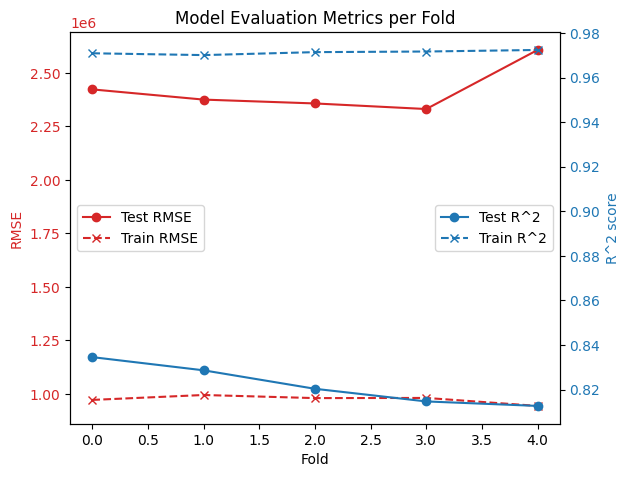

In [17]:
get_error_graph(get_error_df(cv_results))

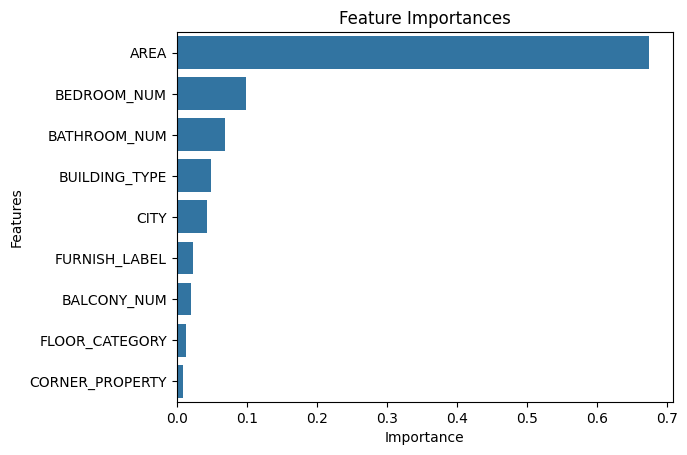

In [26]:
pipeline.fit(X_train, y_train.values.reshape(6264,))
feature_importances = pipeline.named_steps['model'].feature_importances_
feature_names = X_train.columns
feature_importances_df = pd.DataFrame({'Feature Importance': feature_importances}, index=feature_names).sort_values('Feature Importance', ascending=False)
feature_importances_df = feature_importances_df.reset_index()
feature_importances_df.columns = ['Feature', 'Feature Importance']
sns.barplot(x='Feature Importance', y='Feature', data=feature_importances_df.sort_values('Feature Importance', ascending=False))
plt.title('Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()

## Hyper Parameter Tuning on Random Forest

In [27]:
preprocessing = ColumnTransformer([
    ('oe', OrdinalEncoder(), [0, 1, 2, 3, 4])
], remainder='passthrough')

pipeline = Pipeline([
    ('preprocessing', preprocessing),
    ('model', RandomForestRegressor(random_state=42))
])

param_grid = {
    'model__n_estimators': [100, 200, 300],
    'model__max_depth': [None, 10, 20, 30],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4],
    'model__max_features': [None, 'sqrt', 'log2'],
    'model__bootstrap': [True, False]
}

# Set up GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid, cv=KFold(n_splits=5, shuffle=True, random_state=42),
                           scoring={'RMSE': rmse_scorer, 'r2': 'r2'}, 
                           refit='RMSE', # Refit using the best RMSE score
                           return_train_score=True,
                           n_jobs=-1)

# Perform the search
grid_search.fit(X_train, y_train)

# Best parameter set
print("Best parameters found: ")
print(grid_search.best_params_)

# Results of the grid search
results = pd.DataFrame(grid_search.cv_results_)

C:\Users\baps\anaconda3\lib\site-packages\sklearn\pipeline.py:405: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


Best parameters found: 
{'model__bootstrap': True, 'model__max_depth': 20, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 1, 'model__min_samples_split': 10, 'model__n_estimators': 300}


In [28]:
preprocessing = ColumnTransformer([
    ('oe', OrdinalEncoder(), [0, 1, 2, 3, 4])
], remainder='passthrough')

pipeline = Pipeline([
    ('preprocessing', preprocessing),
    ('model', RandomForestRegressor(n_estimators=300, bootstrap=True, max_depth=20,
                                    max_features='sqrt', min_samples_leaf=1, min_samples_split=10, random_state=42))
])

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

rmse_scorer = make_scorer(rmse, greater_is_better=False)

cv = KFold(n_splits=10, shuffle=True, random_state=42)
cv_results = cross_validate(pipeline, X_train, y_train, n_jobs=-1,
                            scoring={'RMSE': rmse_scorer, 'r2': 'r2'},
                            cv=cv,
                            return_train_score=True)

In [29]:
error_df = get_error_df(cv_results)

In [30]:
print('Train RMSE: ', error_df.mean().iloc[1], '   Train RMSE STD: ', error_df.std().iloc[1])
print('Test RMSE: ', error_df.mean().iloc[0], '   Test RMSE STD: ', error_df.std().iloc[0])

print('Train R2: ', error_df.mean().iloc[3], '   Train R2 STD: ', error_df.std().iloc[3])
print('Test R2: ', error_df.mean().iloc[2], '   Test R2 STD: ', error_df.std().iloc[2])

Train RMSE:  1780460.7505729408    Train RMSE STD:  12381.07572802712
Test RMSE:  2375780.262078707    Test RMSE STD:  156660.2211450237
Train R2:  0.9041196923971693    Train R2 STD:  0.00113923595080243
Test R2:  0.8281696764469343    Test R2 STD:  0.0167321921185031


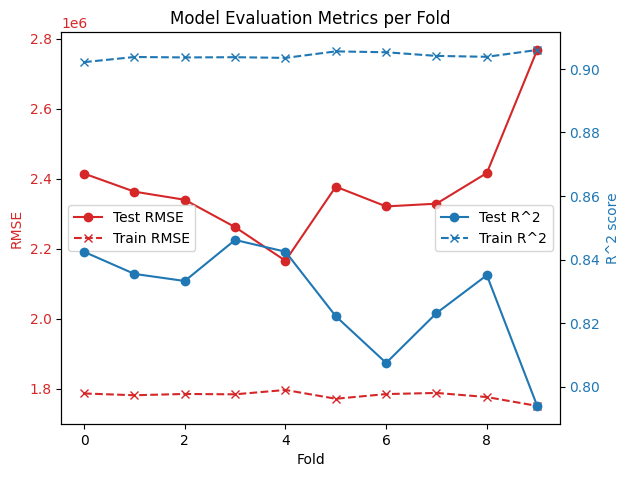

In [31]:
get_error_graph(get_error_df(cv_results))

C:\Users\baps\anaconda3\lib\site-packages\sklearn\pipeline.py:405: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


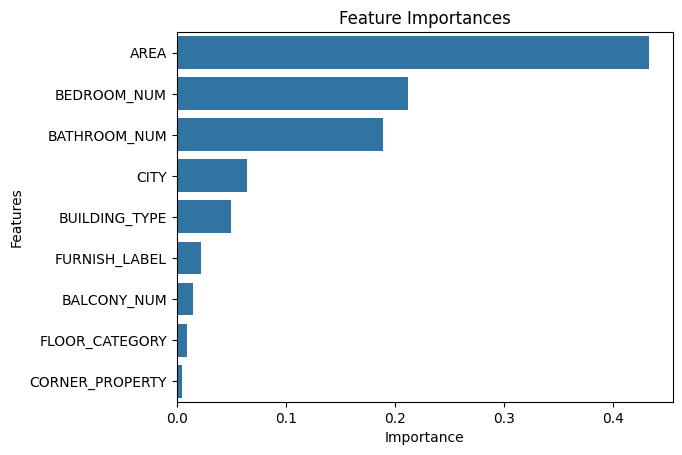

In [32]:
pipeline.fit(X_train, y_train)

feature_importances = pipeline.named_steps['model'].feature_importances_
feature_names = X_train.columns
feature_importances_df = pd.DataFrame({'Feature Importance': feature_importances}, index=feature_names).sort_values('Feature Importance', ascending=False)
feature_importances_df = feature_importances_df.reset_index()
feature_importances_df.columns = ['Feature', 'Feature Importance']
sns.barplot(x='Feature Importance', y='Feature', data=feature_importances_df.sort_values('Feature Importance', ascending=False))
plt.title('Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()

In [33]:
y_train_pred = pipeline.predict(X_train)
y_test_pred = pipeline.predict(X_test)

print('Train RMSE: ', mean_squared_error(y_train, y_train_pred)**0.5)
print('Test RMSE: ', mean_squared_error(y_test, y_test_pred)**0.5)

print('Train R2: ', r2_score(y_train, y_train_pred))
print('Test R2: ', r2_score(y_test, y_test_pred))

Train RMSE:  1775194.7395160696
Test RMSE:  2248468.5460348553
Train R2:  0.9046952079801813
Test R2:  0.8443406254389361


## Final

In [62]:
input_cols = ['CITY', 'BUILDING_TYPE', 'FURNISH_LABEL', 'BEDROOM_NUM', 'BATHROOM_NUM', 'BALCONY_NUM', 'AREA']
target_cols = ['PRICE']

X = df[input_cols]
y = df[target_cols]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.shape, X_test.shape

preprocessing = ColumnTransformer([
    ('oe', OrdinalEncoder(), [0, 1, 2])
], remainder='passthrough')

pipeline = Pipeline([
    ('preprocessing', preprocessing),
    ('model', RandomForestRegressor(n_estimators=300, bootstrap=True, max_depth=20,
                                    max_features='sqrt', min_samples_leaf=1, min_samples_split=10, random_state=42))
])

pipeline.fit(X_train, y_train)

y_train_pred = pipeline.predict(X_train)
y_test_pred = pipeline.predict(X_test)

print('Train RMSE: ', mean_squared_error(y_train, y_train_pred)**0.5)
print('Test RMSE: ', mean_squared_error(y_test, y_test_pred)**0.5)

print('Train R2: ', r2_score(y_train, y_train_pred))
print('Test R2: ', r2_score(y_test, y_test_pred))

C:\Users\baps\anaconda3\lib\site-packages\sklearn\pipeline.py:405: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


Train RMSE:  1773284.3093820068
Test RMSE:  2239813.425316653
Train R2:  0.9049002279374296
Test R2:  0.8455366907936539


In [65]:
from sklearn.ensemble import GradientBoostingRegressor

In [141]:
# Assuming df is your DataFrame and has been defined earlier
input_cols = ['CITY', 'BUILDING_TYPE', 'FURNISH_LABEL', 'BEDROOM_NUM', 'BATHROOM_NUM', 'BALCONY_NUM', 'AREA']
target_cols = ['PRICE']

X = df[input_cols]
y = df[target_cols]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)

# Preprocessing
preprocessing = ColumnTransformer([
    ('oe', OrdinalEncoder(), [0, 1, 2])
], remainder='passthrough')

# Update the model in the pipeline to GradientBoostingRegressor
pipeline = Pipeline([
    ('preprocessing', preprocessing),
    ('model', GradientBoostingRegressor(n_estimators=300, learning_rate=0.01, max_depth=5,
                                         max_features='sqrt', min_samples_leaf=5, min_samples_split=20, random_state=1))
])

pipeline.fit(X_train, y_train.values.ravel())  # Assuming y_train is a DataFrame and needs to be raveled for sklearn

y_train_pred = pipeline.predict(X_train)
y_test_pred = pipeline.predict(X_test)

print('Train RMSE: ', mean_squared_error(y_train, y_train_pred, squared=False))  # squared=False returns RMSE directly
print('Test RMSE: ', mean_squared_error(y_test, y_test_pred, squared=False))

print('Train R2: ', r2_score(y_train, y_train_pred))
print('Test R2: ', r2_score(y_test, y_test_pred))

X_train shape: (6264, 7)
X_test shape: (1566, 7)
Train RMSE:  2400177.7363501997
Test RMSE:  2442097.8777877972
Train R2:  0.8270959782626244
Test R2:  0.8105137971451514
